## Import code

In [1]:
%load_ext autoreload
%autoreload 2 
# Autoreloads packages when changes are detected

from src.Data import * # Class containing the data
from src.Assignment import * # Class containing an assignment
from src.Model import * # Class containing a Pulp model used for optimization
from src.ModelColumnGen import * # Class containing Pulp model that optimizes using column generation
from src.ModelFracStable import * # Class containing a Pulp model for finding an fractionally stable stochastic improvement
from src.ModelHeuristicLP import * # Class containing heuristic that will use generated weakly stable matchings as an input
from src.DataGen import * # Generate student preferences and school priorities
from src.DataGenEE import * # Generate data according to the method by Erdil & Ergin (2008)
from src.DA_STB import * # Generate DA assignment with single tie-breaking (STB)
from src.ErdilErgin import * # Erdil & Ergil their implementation of Stable Improvement Cycles algorithm + alternative implementation DA
from src.SICs import * # Adaptation of SICs algorithm to our code
from src.Simulations import * # Run solution methods for multiple data instances
from src.SimulationsEvaluate import * # Functions that evaluate simulation results

from ReadData.Estonia.Estonia import * # Read Estonian data

import pickle # to export data

# If you get error that pulp and gurobipy are not installed: uncomment following lines in src/Data file:(keep exclamation marks)
    #! pip install pulp
    #! pip install gurobipy

## Column generation formulation

In [ ]:
# Generate random data
parameters = DataGenParam(mean_pref = 5, capacity_ratio = 1) # Default parameters, except for mean_pref and capacity_ratio
#MyData = generate_data(n_students=400, n_schools=20, parameters = parameters, name="Test_DataGen", print_data=False, seed = 15)
#[n_students,n_schools,seed] = [40,10,10]
#[n_students,n_schools,seed] = [50,12,10] # Nice, good illustration of results!
#[n_students,n_schools,seed] = [35,15,0] # Clean simple example where EE has no improvement and we have
[n_students,n_schools,seed] = [200,15,10] # Larger. No improvement upon heuristic. But still, heuristic improves quite a lot on EE (93 instead of 90, avg 0.43 instead of 0.38 improvement)
name = str(n_students) + "_" + str(n_schools) + "_" + str(seed)
MyData = generate_data(n_students = n_students, n_schools=n_schools, parameters = parameters, name=name, print_data=False, seed = seed)

In [ ]:
# Print data if desired
print(MyData)

In [ ]:
# Generate the assignment from DA with Single Tie-Breaking with n_iter samples
n_iter = 400
bool_SIC = False # Run SICs immediately?
A = DA_STB(MyData, n_iter, 'GS', bool_SIC, 0, True)

# Find Stable improvement cycles à la Erdil and Ergin (2008)
A_SIC = SIC_all_matchings(MyData, A, True)

In [ ]:
# Solve the formulations
MyModel = ModelColumnGen(MyData, A_SIC, A.assignment, True)
    # Will use matchings in A_SIC to sd_dominate the assignment 'A.assignment' (found by DA)
    
S = MyModel.Solve("TRAD", "GUROBI", print_log=True, time_limit= 20, print_out=True)
#q = MyModel.Solve("STABLE", "GUROBI", True)

In [ ]:
print(S.A.assignment)
print(S.Xdecomp)
print(S.Xdecomp_coeff)

In [ ]:
# Asses and visualize the difference
name_diff = name + '_diff'
diff = Assignment(MyData, S.A.assignment - S.A_DA_prob, name_diff)
diffEE = Assignment(MyData, S.A.assignment - S.A_SIC.assignment)
diff.visualize()
diffEE.visualize()

In [ ]:
# Compare resulting assignment with DA
result = S.A.compare(S.A_DA_prob)
resultEE = S.A_SIC.compare(S.A_DA_prob)
print("Number of improving students EE & us", resultEE['n_students_improving'], result['n_students_improving'])
print("Average improvement rank EE & us", resultEE['average_rank_increase'], result["average_rank_increase"])
print("Median rank improvement", resultEE['median_rank_improvement'], result['median_rank_improvement'])


In [ ]:
# Export data using pickle
A = [0, S]
print(A[1])

# Save to file
with open('pickle_test.pkl', 'wb') as f:
    pickle.dump(A, f)

# Later, load it back
with open('pickle_test.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

print(A[1].A.assignment)


# Column generation Erdil & Ergin data

In [2]:
n_stud = 100
n_schools = 8
pref_list_length = n_schools
alpha_in = 0.3
beta_in = 0.5
seed = 10
MyData = DataGenEE(n_stud, n_schools, alpha_in, beta_in, pref_list_length, True, seed)
print(MyData)

The data instance has the following properties: 

	100 students.
	8 schools. 

 	PREFERENCES:
	0	0 4 3 1 2 5 7 6 
	1	0 4 1 7 5 6 3 2 
	2	5 0 7 2 1 4 3 6 
	3	7 0 4 3 6 2 5 1 
	4	7 3 2 0 4 5 6 1 
	5	0 3 4 6 1 2 7 5 
	6	4 7 1 3 5 2 6 0 
	7	0 1 7 4 3 6 5 2 
	8	2 6 4 5 0 1 3 7 
	9	5 0 4 2 7 1 3 6 
	10	4 1 3 2 7 0 6 5 
	11	3 0 5 4 7 1 2 6 
	12	0 1 4 3 2 7 5 6 
	13	0 1 7 2 3 4 6 5 
	14	7 3 6 2 0 4 5 1 
	15	1 2 4 7 5 0 3 6 
	16	4 0 7 2 1 3 6 5 
	17	4 2 6 5 0 7 3 1 
	18	3 2 1 5 6 7 0 4 
	19	3 4 1 5 6 0 7 2 
	20	5 4 7 0 1 2 3 6 
	21	0 7 1 2 3 4 6 5 
	22	7 4 1 0 3 2 5 6 
	23	7 4 1 5 0 6 2 3 
	24	1 0 7 3 4 6 5 2 
	25	1 3 7 4 6 0 2 5 
	26	1 0 7 3 5 6 2 4 
	27	1 4 5 6 0 2 7 3 
	28	7 1 0 2 4 3 6 5 
	29	4 0 3 5 7 2 6 1 
	30	7 1 4 2 0 5 3 6 
	31	4 2 1 3 6 0 5 7 
	32	0 4 3 7 2 1 6 5 
	33	2 4 5 3 7 6 0 1 
	34	7 0 4 5 3 6 1 2 
	35	0 2 3 1 6 5 7 4 
	36	6 0 1 4 3 7 5 2 
	37	3 6 2 7 0 4 5 1 
	38	7 1 4 0 5 6 3 2 
	39	0 3 2 7 4 5 1 6 
	40	0 2 3 6 4 1 5 7 
	41	4 5 7 3 0 6 2 1 
	42	4 7 3 6 2 0 1 5 
	43	1 6 0 3 7

In [3]:
# Generate the assignment from DA with Single Tie-Breaking with n_iter samples
n_iter = 1000
bool_SIC = False # Run SICs immediately?
A = DA_STB(MyData, n_iter, 'GS', bool_SIC, 0, True)

# Find Stable improvement cycles à la Erdil and Ergin (2008)
A_SIC = SIC_all_matchings(MyData, A, True)

Students in ties: 100
Tie-breaking rules needed: 93326215443944152681699238856266700490715968264381621468592963895217599993229915608941463976156518286253697920827223758251185210916864000000000000000000000000
Tie-breaking rules sampled: 1000


Generate DA_STB: 100%|██████████| 1000/1000 [00:06<00:00, 159.26perturb/s]


STATISTICS BEFORE:

Average rank: 2.0559499999999993.



Compute SICs for matchings: 100%|██████████| 1000/1000 [00:01<00:00, 716.16matching/s]


STATISTICS AFTER:

Average rank: 1.7612100000000013.



In [ ]:
# Solve the formulations
MyModel = ModelColumnGen(MyData, A_SIC, A.assignment, True)
    # Will use matchings in A_SIC to sd_dominate the assignment 'A.assignment' (found by DA)
    
S = MyModel.Solve("TRAD", "GUROBI", print_log=True, time_limit= 3600, n_sol_pricing = 10000, gap_pricing= 0.1, print_out=True)
#q = MyModel.Solve("STABLE", "GUROBI", True)

Master: add decision variables: 100%|██████████| 1000/1000 [00:03<00:00, 261.47var/s]



Average rank DA : 2.0559499999999993.


Average rank warm start solution : 1.7612100000000013.




Pricing exclude found matchings: 100%|██████████| 1000/1000 [00:07<00:00, 139.74matchings/s]


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1185G7 @ 3.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 801 rows, 1000 columns and 724879 nonzeros
Model fingerprint: 0xb6d39c47
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+00]
Presolve removed 596 rows and 0 columns
Presolve time: 0.07s
Presolved: 205 rows, 1000 columns, 132182 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.091e+04
 Factor NZ  : 2.112e+04 (roughly 1 MB of memory)
 Factor Ops : 2.893e+06 (less than 1 second per iteration)
 Threads    : 3

Barrier performed 0 iterations in 0.13 s

In [ ]:
print(len(S.Xdecomp))
print(len(MyModel.w))

10854
10854


In [5]:
# Compare resulting assignment with DA
result = S.A.compare(S.A_DA_prob)
resultEE = S.A_SIC.compare(S.A_DA_prob)
print(resultEE)
print(result)
print("Number of improving students EE & us", resultEE['n_students_improving'], result['n_students_improving'])
print("Average improvement rank EE & us", resultEE['average_rank_increase'], result["average_rank_increase"])
print("Median rank improvement", resultEE['median_rank_improvement'], result['median_rank_improvement'])


{'students_improving': [True, False, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, False, False, False, True, True, True, True, False, True, True, True, True, True, False, False, True, True, True, False, False, True, False, True, True, True, False, True, True, True, True, False, True, True, True, True, False, False, False, False, False, True, False, True, True, True, True, False, True, True, False, True, True, True, True, True, True, False, True, True, True, True, False, True, True, True, True, False, False, True, True, True, False, True, True, True, True, True, True, True, True, True, False], 'n_students_improving': 73, 'rank_increase_by_stud': [0.003999999999998893, 0, 0.4649999999999994, 0.0749999999999984, 0.27799999999999847, 0.003999999999998671, 0.003999999999999337, 0.09499999999999753, 0, 0.23999999999999932, 0.569999999999999, 1.026999999999999, 0.15199999999999836, 0.08099999999999885, 0.05599999999999872, 0.5389999999999979

In [ ]:
# # Asses and visualize the difference
# name_diff = MyData.file_name + '_diff'
# diff = Assignment(MyData, S.A.assignment - S.A_DA_prob, name_diff)
# diffEE = Assignment(MyData, S.A.assignment - S.A_SIC.assignment)
# diff.visualize() # Difference compared to DA
# diffEE.visualize() # Difference compared to EE

# Simulations

In [23]:
n_students = [30]
n_schools = [6]
n_iterations_simul = 5
n_match = 1000
time_lim = 30
seed = 0

ALPHA_INCREMENT = 0.2
BETA_INCREMENT = 0.2

alpha = list(np.arange(0, 1.0, ALPHA_INCREMENT)) + [1.0]
#beta = list(np.arange(0, 1.0, BETA_INCREMENT)) + [1.0]
beta = [0.5]
print(alpha)
S_vector = SimulationCG(n_students, n_schools, alpha, beta, n_iterations_simul, n_match, time_lim, seed, True)


[0.0, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0]


Data instances:   0%|          | 0/6 [00:00<?, ?inst/s]

n,m,alpha, beta, seed 30 6 0.0 0.5 906691059
Students in ties: 30
Tie-breaking rules needed: 265252859812191058636308480000000
Tie-breaking rules sampled: 1000















Generate DA_STB: 100%|██████████| 1000/1000 [00:01<00:00, 759.41perturb/s]





Master: add decision variables: 100%|██████████| 744/744 [00:00<00:00, 1240.67var/s]



Average rank DA : 1.4381000000000002.


Average rank warm start solution : 1.3412333333333348.














Pricing exclude found matchings: 100%|██████████| 744/744 [00:01<00:00, 623.15matchings/s]


Number of matchings: 744
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.2718333333333336
Constant term 0.9000000000000005

 ****** PRICING ****** 

New time limit 29.54700000002049
		Objective pricing:  2.6666666666666705
Pricing status 1
New number of matchings: 745
ITERATION: 2

 ****** MASTER ****** 

Objective master:  1.2718333333333336
Constant term 0.9000000000000005

 ****** PRICING ****** 

New time limit 29.016000000061467
		Objective pricing:  2.6666666666666683
Pricing status 1
New number of matchings: 746
ITERATION: 3

 ****** MASTER ****** 

Objective master:  1.2718333333333336
Constant term 0.9000000000000005

 ****** PRICING ****** 

New time limit 28.453999999910593
		Objective pricing:  2.6666666666666687
Pricing status 1
New number of matchings: 747
ITERATION: 4

 ****** MASTER ****** 

Objective master:  1.2718333333333336
Constant term 0.9000000000000005

 ****** PRICING ****** 

New time limit 27.891000000061467
		Objective pricing:  2.666666666666669

n,m,alpha, beta, seed 30 6 0.0 0.5 413653999
Students in ties: 30
Tie-breaking rules needed: 265252859812191058636308480000000
Tie-breaking rules sampled: 1000















Generate DA_STB: 100%|██████████| 1000/1000 [00:01<00:00, 748.51perturb/s]






Master: add decision variables: 100%|██████████| 789/789 [00:00<00:00, 1286.27var/s]



Average rank DA : 1.5862666666666667.


Average rank warm start solution : 1.439033333333335.














Pricing exclude found matchings: 100%|██████████| 789/789 [00:03<00:00, 211.84matchings/s]


Number of matchings: 789
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.3840666666666672
Constant term -0.2666666666666655

 ****** PRICING ****** 

New time limit 29.70299999997951
		Objective pricing:  7.633333746346018
Pricing status 1
New number of matchings: 790
ITERATION: 2

 ****** MASTER ****** 

Objective master:  1.3840666666666672
Constant term -0.2666666666666658

 ****** PRICING ****** 

New time limit 28.92200000002049
		Objective pricing:  7.933333333333339
Pricing status 1
New number of matchings: 791
ITERATION: 3

 ****** MASTER ****** 

Objective master:  1.3840666666666672
Constant term -0.2666666666666658

 ****** PRICING ****** 

New time limit 27.780999999959022
		Objective pricing:  7.933333333333339
Pricing status 1
New number of matchings: 792
ITERATION: 4

 ****** MASTER ****** 

Objective master:  1.3840666666666672
Constant term -0.2666666666666658

 ****** PRICING ****** 

New time limit 26.484999999869615
		Objective pricing:  7.933333333333339

n,m,alpha, beta, seed 30 6 0.0 0.5 813847339
Students in ties: 30
Tie-breaking rules needed: 265252859812191058636308480000000
Tie-breaking rules sampled: 1000




















Generate DA_STB: 100%|██████████| 1000/1000 [00:01<00:00, 504.13perturb/s]











Master: add decision variables: 100%|██████████| 765/765 [00:01<00:00, 633.77var/s]



Average rank DA : 1.3497666666666668.


Average rank warm start solution : 1.2955666666666672.

















Pricing exclude found matchings: 100%|██████████| 765/765 [00:01<00:00, 512.45matchings/s]


Number of matchings: 765
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.2365333333333335
Constant term 0.5999999999999981

 ****** PRICING ****** 

New time limit 29.5
		Objective pricing:  3.866666666666685
Pricing status 1
New number of matchings: 766
ITERATION: 2

 ****** MASTER ****** 

Objective master:  1.2365333333333335
Constant term 0.5999999999999992

 ****** PRICING ****** 

New time limit 28.858999999938533
		Objective pricing:  3.866666666666673
Pricing status 1
New number of matchings: 767
ITERATION: 3

 ****** MASTER ****** 

Objective master:  1.2365333333333335
Constant term 0.5999999999999992

 ****** PRICING ****** 

New time limit 28.187999999849126
		Objective pricing:  3.8666666666666734
Pricing status 1
New number of matchings: 768
ITERATION: 4

 ****** MASTER ****** 

Objective master:  1.2365333333333335
Constant term 0.5999999999999992

 ****** PRICING ****** 

New time limit 27.5
		Objective pricing:  3.8666666666666734
Pricing status 1
New number

n,m,alpha, beta, seed 30 6 0.0 0.5 955892128
Students in ties: 30
Tie-breaking rules needed: 265252859812191058636308480000000
Tie-breaking rules sampled: 1000














Generate DA_STB: 100%|██████████| 1000/1000 [00:01<00:00, 772.84perturb/s]


Master: add decision variables: 100%|██████████| 184/184 [00:00<00:00, 1504.12var/s]



Average rank DA : 1.2580666666666669.


Average rank warm start solution : 1.2238000000000004.







Pricing exclude found matchings: 100%|██████████| 184/184 [00:00<00:00, 892.76matchings/s]


Number of matchings: 184
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.2138666666666666
Constant term -0.06666666666666621

 ****** PRICING ****** 

New time limit 29.938000000081956
		Objective pricing:  6.366666666666668
Pricing status 1
New number of matchings: 185
ITERATION: 2

 ****** MASTER ****** 

Objective master:  1.2138666666666666
Constant term -0.06666666666666621

 ****** PRICING ****** 

New time limit 29.719000000040978
		Objective pricing:  6.300000000000002
Pricing status 1
New number of matchings: 186
ITERATION: 3

 ****** MASTER ****** 

Objective master:  1.2138666666666666
Constant term -0.06666666666666621

 ****** PRICING ****** 

New time limit 29.484999999869615
		Objective pricing:  6.300000000000002
Pricing status 1
New number of matchings: 187
ITERATION: 4

 ****** MASTER ****** 

Objective master:  1.2138666666666666
Constant term -0.06666666666666621

 ****** PRICING ****** 

New time limit 29.266000000061467
		Objective pricing:  6.100000000

n,m,alpha, beta, seed 30 6 0.0 0.5 451585301
Students in ties: 30
Tie-breaking rules needed: 265252859812191058636308480000000
Tie-breaking rules sampled: 1000















Generate DA_STB: 100%|██████████| 1000/1000 [00:01<00:00, 745.06perturb/s]





Master: add decision variables: 100%|██████████| 610/610 [00:00<00:00, 1197.60var/s]



Average rank DA : 1.4646000000000006.


Average rank warm start solution : 1.3700666666666674.















Pricing exclude found matchings: 100%|██████████| 610/610 [00:01<00:00, 528.68matchings/s]


Number of matchings: 610
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.2978333333333336
Constant term -0.8000000000000057

 ****** PRICING ****** 

New time limit 29.686999999918044
		Objective pricing:  9.26666666666669
Pricing status 1
New number of matchings: 611
ITERATION: 2

 ****** MASTER ****** 

Objective master:  1.2978333333333336
Constant term -0.7999999999999993

 ****** PRICING ****** 

New time limit 29.014999999897555
		Objective pricing:  8.933333333333344
Pricing status 1
New number of matchings: 612
ITERATION: 3

 ****** MASTER ****** 

Objective master:  1.2978333333333336
Constant term -0.8000000000000057

 ****** PRICING ****** 

New time limit 28.264999999897555
		Objective pricing:  9.033333333333355
Pricing status 1
New number of matchings: 613
ITERATION: 4

 ****** MASTER ****** 

Objective master:  1.2978333333333336
Constant term -0.8000000000000057

 ****** PRICING ****** 

New time limit 27.5
		Objective pricing:  9.000000000000021
Pricing stat

Data instances:  17%|█▋        | 1/6 [03:12<16:02, 192.55s/inst]

n,m,alpha, beta, seed 30 6 0.2 0.5 906691059
Students in ties: 30
Tie-breaking rules needed: 265252859812191058636308480000000
Tie-breaking rules sampled: 1000















Generate DA_STB: 100%|██████████| 1000/1000 [00:01<00:00, 740.37perturb/s]




Master: add decision variables: 100%|██████████| 486/486 [00:00<00:00, 1220.86var/s]



Average rank DA : 1.5042333333333338.


Average rank warm start solution : 1.4286333333333345.










Pricing exclude found matchings: 100%|██████████| 486/486 [00:00<00:00, 853.26matchings/s]


Number of matchings: 486
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.3753333333333337
Constant term 1.066666666666666

 ****** PRICING ****** 

New time limit 29.844000000040978
		Objective pricing:  2.2666666666666737
Pricing status 1
New number of matchings: 487
ITERATION: 2

 ****** MASTER ****** 

Objective master:  1.3753333333333337
Constant term 1.066666666666666

 ****** PRICING ****** 

New time limit 29.375
		Objective pricing:  2.2666666666666755
Pricing status 1
New number of matchings: 488
ITERATION: 3

 ****** MASTER ****** 

Objective master:  1.3753333333333337
Constant term 1.066666666666666

 ****** PRICING ****** 

New time limit 28.687999999849126
		Objective pricing:  2.2333333333333423
Pricing status 1
New number of matchings: 489
ITERATION: 4

 ****** MASTER ****** 

Objective master:  1.3753333333333337
Constant term 1.066666666666666

 ****** PRICING ****** 

New time limit 27.984999999869615
		Objective pricing:  2.2333333333333405
Pricing statu

n,m,alpha, beta, seed 30 6 0.2 0.5 413653999
Students in ties: 30
Tie-breaking rules needed: 265252859812191058636308480000000
Tie-breaking rules sampled: 1000















Generate DA_STB: 100%|██████████| 1000/1000 [00:01<00:00, 750.19perturb/s]







Master: add decision variables: 100%|██████████| 778/778 [00:00<00:00, 1074.54var/s]



Average rank DA : 1.8462000000000003.


Average rank warm start solution : 1.6239666666666686.













Pricing exclude found matchings: 100%|██████████| 778/778 [00:00<00:00, 795.93matchings/s]


Number of matchings: 778
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.587833333333334
Constant term -0.4333333333333306

 ****** PRICING ****** 

New time limit 29.719000000040978
		Objective pricing:  8.799999999999999
Pricing status 1
New number of matchings: 779
ITERATION: 2

 ****** MASTER ****** 

Objective master:  1.587833333333334
Constant term -0.4333333333333306

 ****** PRICING ****** 

New time limit 27.82799999997951
		Objective pricing:  8.766666666666666
Pricing status 1
New number of matchings: 780
ITERATION: 3

 ****** MASTER ****** 

Objective master:  1.587833333333334
Constant term -0.4333333333333306

 ****** PRICING ****** 

New time limit 26.109999999869615
		Objective pricing:  8.733333333333333
Pricing status 1
New number of matchings: 781
ITERATION: 4

 ****** MASTER ****** 

Objective master:  1.587833333333334
Constant term -0.4333333333333306

 ****** PRICING ****** 

New time limit 24.516000000061467
		Objective pricing:  8.733333333333333
Pr

n,m,alpha, beta, seed 30 6 0.2 0.5 813847339
Students in ties: 30
Tie-breaking rules needed: 265252859812191058636308480000000
Tie-breaking rules sampled: 1000
















Generate DA_STB: 100%|██████████| 1000/1000 [00:01<00:00, 689.12perturb/s]







Master: add decision variables: 100%|██████████| 823/823 [00:00<00:00, 1182.74var/s]



Average rank DA : 1.4433.


Average rank warm start solution : 1.3566000000000005.













Pricing exclude found matchings: 100%|██████████| 823/823 [00:00<00:00, 941.30matchings/s]


Number of matchings: 823
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.2891666666666672
Constant term 0.8333333333333335

 ****** PRICING ****** 

New time limit 29.734999999869615
		Objective pricing:  2.8000000000000016
Pricing status 1
New number of matchings: 824
ITERATION: 2

 ****** MASTER ****** 

Objective master:  1.2891666666666672
Constant term 0.8333333333333335

 ****** PRICING ****** 

New time limit 29.32799999997951
		Objective pricing:  2.8000000000000016
Pricing status 1
New number of matchings: 825
ITERATION: 3

 ****** MASTER ****** 

Objective master:  1.2891666666666672
Constant term 0.8333333333333335

 ****** PRICING ****** 

New time limit 28.891000000061467
		Objective pricing:  2.7333333333333343
Pricing status 1
New number of matchings: 826
ITERATION: 4

 ****** MASTER ****** 

Objective master:  1.2891666666666672
Constant term 0.8333333333333335

 ****** PRICING ****** 

New time limit 28.5
		Objective pricing:  2.666666666666668
Pricing statu

n,m,alpha, beta, seed 30 6 0.2 0.5 955892128
Students in ties: 30
Tie-breaking rules needed: 265252859812191058636308480000000
Tie-breaking rules sampled: 1000














Generate DA_STB: 100%|██████████| 1000/1000 [00:01<00:00, 831.09perturb/s]







Master: add decision variables: 100%|██████████| 957/957 [00:00<00:00, 1185.37var/s]



Average rank DA : 1.7567666666666664.


Average rank warm start solution : 1.716866666666668.















Pricing exclude found matchings: 100%|██████████| 957/957 [00:01<00:00, 801.96matchings/s]


Number of matchings: 957
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.655333333333334
Constant term 0.23333333333333517

 ****** PRICING ****** 

New time limit 29.734999999869615
		Objective pricing:  6.7333333333333325
Pricing status 1
New number of matchings: 958
ITERATION: 2

 ****** MASTER ****** 

Objective master:  1.655333333333334
Constant term 0.23333333333333517

 ****** PRICING ****** 

New time limit 29.125
		Objective pricing:  6.599999999999999
Pricing status 1
New number of matchings: 959
ITERATION: 3

 ****** MASTER ****** 

Objective master:  1.655333333333334
Constant term 0.23333333333333517

 ****** PRICING ****** 

New time limit 28.594000000040978
		Objective pricing:  6.666666666666664
Pricing status 1
New number of matchings: 960
ITERATION: 4

 ****** MASTER ****** 

Objective master:  1.655333333333334
Constant term 0.23333333333333517

 ****** PRICING ****** 

New time limit 27.92200000002049
		Objective pricing:  6.666666666666667
Pricing statu

n,m,alpha, beta, seed 30 6 0.2 0.5 451585301
Students in ties: 30
Tie-breaking rules needed: 265252859812191058636308480000000
Tie-breaking rules sampled: 1000
















Generate DA_STB: 100%|██████████| 1000/1000 [00:01<00:00, 716.82perturb/s]








Master: add decision variables: 100%|██████████| 975/975 [00:00<00:00, 1112.11var/s]



Average rank DA : 1.8680666666666665.


Average rank warm start solution : 1.746700000000001.














Pricing exclude found matchings: 100%|██████████| 975/975 [00:01<00:00, 931.94matchings/s]


Number of matchings: 975
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.6647666666666678
Constant term -2.0333333333333425

 ****** PRICING ****** 

New time limit 29.688000000081956
		Objective pricing:  14.900000000000023
Pricing status 1
New number of matchings: 976
ITERATION: 2

 ****** MASTER ****** 

Objective master:  1.6647666666666678
Constant term -2.0333333333333425

 ****** PRICING ****** 

New time limit 29.141000000061467
		Objective pricing:  14.833333333333357
Pricing status 1
New number of matchings: 977
ITERATION: 3

 ****** MASTER ****** 

Objective master:  1.6647666666666678
Constant term -2.0333333333333425

 ****** PRICING ****** 

New time limit 28.54700000002049
		Objective pricing:  14.833333333333357
Pricing status 1
New number of matchings: 978
ITERATION: 4

 ****** MASTER ****** 

Objective master:  1.6647666666666678
Constant term -2.0333333333333425

 ****** PRICING ****** 

New time limit 28.078999999910593
		Objective pricing:  14.8000000000

Data instances:  33%|███▎      | 2/6 [06:34<13:12, 198.15s/inst]

n,m,alpha, beta, seed 30 6 0.4 0.5 906691059
Students in ties: 30
Tie-breaking rules needed: 265252859812191058636308480000000
Tie-breaking rules sampled: 1000















Generate DA_STB: 100%|██████████| 1000/1000 [00:01<00:00, 765.47perturb/s]






Master: add decision variables: 100%|██████████| 720/720 [00:00<00:00, 1092.12var/s]



Average rank DA : 2.150399999999999.


Average rank warm start solution : 2.110100000000001.













Pricing exclude found matchings: 100%|██████████| 720/720 [00:00<00:00, 741.09matchings/s]


Number of matchings: 720
ITERATION: 1

 ****** MASTER ****** 

Objective master:  2.067433333333334
Constant term 0.3666666666666629

 ****** PRICING ****** 

New time limit 29.780999999959022
		Objective pricing:  3.333333333333342
Pricing status 1
New number of matchings: 721
ITERATION: 2

 ****** MASTER ****** 

Objective master:  2.067433333333334
Constant term 0.3666666666666629

 ****** PRICING ****** 

New time limit 29.139999999897555
		Objective pricing:  3.3000000000000087
Pricing status 1
New number of matchings: 722
ITERATION: 3

 ****** MASTER ****** 

Objective master:  2.067433333333334
Constant term 0.3666666666666629

 ****** PRICING ****** 

New time limit 28.593999999808148
		Objective pricing:  3.3000000000000087
Pricing status 1
New number of matchings: 723
ITERATION: 4

 ****** MASTER ****** 

Objective master:  2.067433333333334
Constant term 0.3666666666666629

 ****** PRICING ****** 

New time limit 28.093999999808148
		Objective pricing:  3.3000000000000087
Pr

n,m,alpha, beta, seed 30 6 0.4 0.5 413653999
Students in ties: 30
Tie-breaking rules needed: 265252859812191058636308480000000
Tie-breaking rules sampled: 1000















Generate DA_STB: 100%|██████████| 1000/1000 [00:01<00:00, 783.31perturb/s]







Master: add decision variables: 100%|██████████| 895/895 [00:00<00:00, 1184.50var/s]



Average rank DA : 2.470233333333334.


Average rank warm start solution : 2.3840333333333343.














Pricing exclude found matchings: 100%|██████████| 895/895 [00:01<00:00, 852.49matchings/s]


Number of matchings: 895
ITERATION: 1

 ****** MASTER ****** 

Objective master:  2.351066666666667
Constant term 0.6333333333333382

 ****** PRICING ****** 

New time limit 29.781000000191852
		Objective pricing:  4.599999999999991
Pricing status 1
New number of matchings: 896
ITERATION: 2

 ****** MASTER ****** 

Objective master:  2.351066666666667
Constant term 0.6333333333333382

 ****** PRICING ****** 

New time limit 28.015000000130385
		Objective pricing:  4.5666666666666575
Pricing status 1
New number of matchings: 897
ITERATION: 3

 ****** MASTER ****** 

Objective master:  2.351066666666667
Constant term 0.6333333333333382

 ****** PRICING ****** 

New time limit 26.125
		Objective pricing:  4.5666666666666575
Pricing status 1
New number of matchings: 898
ITERATION: 4

 ****** MASTER ****** 

Objective master:  2.351066666666667
Constant term 0.6333333333333382

 ****** PRICING ****** 

New time limit 23.312000000150874
		Objective pricing:  4.566666666666653
Pricing status 

n,m,alpha, beta, seed 30 6 0.4 0.5 813847339
Students in ties: 30
Tie-breaking rules needed: 265252859812191058636308480000000
Tie-breaking rules sampled: 1000














Generate DA_STB: 100%|██████████| 1000/1000 [00:01<00:00, 833.82perturb/s]








Master: add decision variables: 100%|██████████| 996/996 [00:00<00:00, 1112.74var/s]



Average rank DA : 2.082133333333334.


Average rank warm start solution : 1.9451000000000014.















Pricing exclude found matchings: 100%|██████████| 996/996 [00:01<00:00, 910.95matchings/s]


Number of matchings: 996
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.881600000000001
Constant term 0.36666666666666814

 ****** PRICING ****** 

New time limit 29.733999999938533
		Objective pricing:  5.533333333333336
Pricing status 1
New number of matchings: 997
ITERATION: 2

 ****** MASTER ****** 

Objective master:  1.881600000000001
Constant term 0.36666666666666814

 ****** PRICING ****** 

New time limit 29.108999999938533
		Objective pricing:  5.533333333333337
Pricing status 1
New number of matchings: 998
ITERATION: 3

 ****** MASTER ****** 

Objective master:  1.881600000000001
Constant term 0.36666666666666814

 ****** PRICING ****** 

New time limit 28.483999999938533
		Objective pricing:  5.5000000000000036
Pricing status 1
New number of matchings: 999
ITERATION: 4

 ****** MASTER ****** 

Objective master:  1.881600000000001
Constant term 0.36666666666666814

 ****** PRICING ****** 

New time limit 27.844000000040978
		Objective pricing:  5.46666666666667
P

n,m,alpha, beta, seed 30 6 0.4 0.5 955892128
Students in ties: 30
Tie-breaking rules needed: 265252859812191058636308480000000
Tie-breaking rules sampled: 1000















Generate DA_STB: 100%|██████████| 1000/1000 [00:01<00:00, 709.48perturb/s]








Master: add decision variables: 100%|██████████| 993/993 [00:00<00:00, 1146.04var/s]



Average rank DA : 2.135633333333334.


Average rank warm start solution : 2.1202666666666676.














Pricing exclude found matchings: 100%|██████████| 993/993 [00:01<00:00, 948.01matchings/s]


Number of matchings: 993
ITERATION: 1

 ****** MASTER ****** 

Objective master:  2.058933333333334
Constant term -0.30000000000000593

 ****** PRICING ****** 

New time limit 29.687999999849126
		Objective pricing:  7.533333333333361
Pricing status 1
New number of matchings: 994
ITERATION: 2

 ****** MASTER ****** 

Objective master:  2.058933333333334
Constant term -0.30000000000000593

 ****** PRICING ****** 

New time limit 29.20299999997951
		Objective pricing:  7.53333333333336
Pricing status 1
New number of matchings: 995
ITERATION: 3

 ****** MASTER ****** 

Objective master:  2.058933333333334
Constant term -0.30000000000000593

 ****** PRICING ****** 

New time limit 28.70299999997951
		Objective pricing:  7.5000000000000275
Pricing status 1
New number of matchings: 996
ITERATION: 4

 ****** MASTER ****** 

Objective master:  2.058933333333334
Constant term -0.30000000000000593

 ****** PRICING ****** 

New time limit 28.219000000040978
		Objective pricing:  7.500000000000027

n,m,alpha, beta, seed 30 6 0.4 0.5 451585301
Students in ties: 30
Tie-breaking rules needed: 265252859812191058636308480000000
Tie-breaking rules sampled: 1000
















Generate DA_STB: 100%|██████████| 1000/1000 [00:01<00:00, 713.42perturb/s]









Master: add decision variables: 100%|██████████| 998/998 [00:00<00:00, 1007.14var/s]



Average rank DA : 2.1861.


Average rank warm start solution : 2.1335666666666673.
















Pricing exclude found matchings: 100%|██████████| 998/998 [00:01<00:00, 779.43matchings/s]


Number of matchings: 998
ITERATION: 1

 ****** MASTER ****** 

Objective master:  2.0803666666666683
Constant term 0.033333333333331466

 ****** PRICING ****** 

New time limit 29.70300000021234
		Objective pricing:  4.266666666666635
Pricing status 1
New number of matchings: 999
ITERATION: 2

 ****** MASTER ****** 

Objective master:  2.0803666666666683
Constant term 0.033333333333329614

 ****** PRICING ****** 

New time limit 28.968000000109896
		Objective pricing:  4.266666666666685
Pricing status 1
New number of matchings: 1000
ITERATION: 3

 ****** MASTER ****** 

Objective master:  2.0803666666666683
Constant term 0.033333333333329614

 ****** PRICING ****** 

New time limit 28.25
		Objective pricing:  4.266666666666685
Pricing status 1
New number of matchings: 1001
ITERATION: 4

 ****** MASTER ****** 

Objective master:  2.0803666666666683
Constant term 0.033333333333329614

 ****** PRICING ****** 

New time limit 27.343000000109896
		Objective pricing:  4.266666666666685
Prici

Data instances:  50%|█████     | 3/6 [10:23<10:35, 211.99s/inst]

n,m,alpha, beta, seed 30 6 0.6000000000000001 0.5 906691059
Students in ties: 30
Tie-breaking rules needed: 265252859812191058636308480000000
Tie-breaking rules sampled: 1000

















Generate DA_STB: 100%|██████████| 1000/1000 [00:01<00:00, 634.29perturb/s]








Master: add decision variables: 100%|██████████| 1000/1000 [00:00<00:00, 1030.20var/s]



Average rank DA : 2.7683999999999997.


Average rank warm start solution : 2.7684000000000015.
















Pricing exclude found matchings: 100%|██████████| 1000/1000 [00:01<00:00, 826.06matchings/s]


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  2.7675333333333336
Constant term 0.9000000000000011

 ****** PRICING ****** 

New time limit 29.75
		Objective pricing:  4.833333333333337
Pricing status 1
New number of matchings: 1001
ITERATION: 2

 ****** MASTER ****** 

Objective master:  2.7675333333333336
Constant term 0.8999999999999768

 ****** PRICING ****** 

New time limit 29.20299999997951
		Objective pricing:  4.6666666666667
Pricing status 1
New number of matchings: 1002
ITERATION: 3

 ****** MASTER ****** 

Objective master:  2.767533333333334
Constant term 0.8999999999999914

 ****** PRICING ****** 

New time limit 28.655999999959022
		Objective pricing:  4.23333333333336
Pricing status 1
New number of matchings: 1003
ITERATION: 4

 ****** MASTER ****** 

Objective master:  2.7675333333333345
Constant term 0.9000000000000015

 ****** PRICING ****** 

New time limit 26.733999999938533
		Objective pricing:  4.266666666666653
Pricing status 

n,m,alpha, beta, seed 30 6 0.6000000000000001 0.5 413653999
Students in ties: 30
Tie-breaking rules needed: 265252859812191058636308480000000
Tie-breaking rules sampled: 1000















Generate DA_STB: 100%|██████████| 1000/1000 [00:01<00:00, 755.18perturb/s]









Master: add decision variables: 100%|██████████| 984/984 [00:00<00:00, 986.95var/s]



Average rank DA : 2.9315.


Average rank warm start solution : 2.8960000000000012.
















Pricing exclude found matchings: 100%|██████████| 984/984 [00:01<00:00, 850.43matchings/s]


Number of matchings: 984
ITERATION: 1

 ****** MASTER ****** 

Objective master:  2.8643666666666676
Constant term -1.266666666666652

 ****** PRICING ****** 

New time limit 29.719000000040978
		Objective pricing:  6.966666666666665
Pricing status 1
New number of matchings: 985
ITERATION: 2

 ****** MASTER ****** 

Objective master:  2.864366666666669
Constant term -1.2666666666667123

 ****** PRICING ****** 

New time limit 28.875
		Objective pricing:  7.166666666666739
Pricing status 1
New number of matchings: 986
ITERATION: 3

 ****** MASTER ****** 

Objective master:  2.864366666666667
Constant term -1.2666666666666586

 ****** PRICING ****** 

New time limit 28.29700000002049
		Objective pricing:  7.199999999999996
Pricing status 1
New number of matchings: 987
ITERATION: 4

 ****** MASTER ****** 

Objective master:  2.8643666666666667
Constant term -1.2666666666666553

 ****** PRICING ****** 

New time limit 27.70299999997951
		Objective pricing:  7.166666666666677
Pricing status

n,m,alpha, beta, seed 30 6 0.6000000000000001 0.5 813847339
Students in ties: 30
Tie-breaking rules needed: 265252859812191058636308480000000
Tie-breaking rules sampled: 1000
















Generate DA_STB: 100%|██████████| 1000/1000 [00:01<00:00, 682.20perturb/s]









Master: add decision variables: 100%|██████████| 995/995 [00:00<00:00, 997.31var/s]



Average rank DA : 2.858133333333333.


Average rank warm start solution : 2.7087333333333357.















Pricing exclude found matchings: 100%|██████████| 995/995 [00:01<00:00, 871.15matchings/s]


Number of matchings: 995
ITERATION: 1

 ****** MASTER ****** 

Objective master:  2.6348432218626385
Constant term -0.6904950257701118

 ****** PRICING ****** 

New time limit 29.70299999997951
		Objective pricing:  7.037468536497678
Pricing status 1
New number of matchings: 996
ITERATION: 2

 ****** MASTER ****** 

Objective master:  2.6348432218626385
Constant term -0.6904950257701118

 ****** PRICING ****** 

New time limit 28.969000000040978
		Objective pricing:  7.339590075512415
Pricing status 1
New number of matchings: 997
ITERATION: 3

 ****** MASTER ****** 

Objective master:  2.6348432218626385
Constant term -0.6904950257701118

 ****** PRICING ****** 

New time limit 27.32799999997951
		Objective pricing:  7.561069159774663
Pricing status 1
New number of matchings: 998
ITERATION: 4

 ****** MASTER ****** 

Objective master:  2.6348432218626385
Constant term -0.6904950257701118

 ****** PRICING ****** 

New time limit 26.437999999849126
		Objective pricing:  7.504063286587561

n,m,alpha, beta, seed 30 6 0.6000000000000001 0.5 955892128
Students in ties: 30
Tie-breaking rules needed: 265252859812191058636308480000000
Tie-breaking rules sampled: 1000




















Generate DA_STB: 100%|██████████| 1000/1000 [00:01<00:00, 535.46perturb/s]








Master: add decision variables: 100%|██████████| 1000/1000 [00:00<00:00, 1038.51var/s]



Average rank DA : 2.530499999999999.


Average rank warm start solution : 2.528100000000001.


















Pricing exclude found matchings: 100%|██████████| 1000/1000 [00:01<00:00, 663.33matchings/s]


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  2.5161666666666678
Constant term -0.6333333333333409

 ****** PRICING ****** 

New time limit 29.594000000040978
		Objective pricing:  5.233333333333356
Pricing status 1
New number of matchings: 1001
ITERATION: 2

 ****** MASTER ****** 

Objective master:  2.516166666666667
Constant term -0.6333333333333222

 ****** PRICING ****** 

New time limit 28.92200000002049
		Objective pricing:  4.29999999999997
Pricing status 1
New number of matchings: 1002
ITERATION: 3

 ****** MASTER ****** 

Objective master:  2.516166666666666
Constant term -0.6333333333333167

 ****** PRICING ****** 

New time limit 28.108999999938533
		Objective pricing:  5.833333333333329
Pricing status 1
New number of matchings: 1003
ITERATION: 4

 ****** MASTER ****** 

Objective master:  2.516166666666666
Constant term -0.6333333333333162

 ****** PRICING ****** 

New time limit 27.530999999959022
		Objective pricing:  5.16666666666665

n,m,alpha, beta, seed 30 6 0.6000000000000001 0.5 451585301
Students in ties: 30
Tie-breaking rules needed: 265252859812191058636308480000000
Tie-breaking rules sampled: 1000


















Generate DA_STB: 100%|██████████| 1000/1000 [00:02<00:00, 396.14perturb/s]








Master: add decision variables: 100%|██████████| 1000/1000 [00:00<00:00, 1049.04var/s]



Average rank DA : 2.6892000000000014.


Average rank warm start solution : 2.6387666666666694.
















Pricing exclude found matchings: 100%|██████████| 1000/1000 [00:01<00:00, 797.33matchings/s]


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  2.6104000000000007
Constant term 0.6333333333332809

 ****** PRICING ****** 

New time limit 29.733999999938533
		Objective pricing:  4.400000000000152
Pricing status 1
New number of matchings: 1001
ITERATION: 2

 ****** MASTER ****** 

Objective master:  2.6104000000000007
Constant term 0.6333333333333373

 ****** PRICING ****** 

New time limit 27.42200000002049
		Objective pricing:  4.9000000000000234
Pricing status 1
New number of matchings: 1002
ITERATION: 3

 ****** MASTER ****** 

Objective master:  2.6104000000000007
Constant term 0.6333333333331992

 ****** PRICING ****** 

New time limit 25.45299999997951
		Objective pricing:  4.70000000000053
Pricing status 1
New number of matchings: 1003
ITERATION: 4

 ****** MASTER ****** 

Objective master:  2.6104000000000007
Constant term 0.6333333333333475

 ****** PRICING ****** 

New time limit 22.811999999918044
		Objective pricing:  4.933333333333314

Data instances:  67%|██████▋   | 4/6 [14:44<07:42, 231.45s/inst]

n,m,alpha, beta, seed 30 6 0.8 0.5 906691059
Students in ties: 30
Tie-breaking rules needed: 265252859812191058636308480000000
Tie-breaking rules sampled: 1000

















Generate DA_STB: 100%|██████████| 1000/1000 [00:01<00:00, 652.98perturb/s]








Master: add decision variables: 100%|██████████| 1000/1000 [00:00<00:00, 1088.38var/s]



Average rank DA : 3.0530000000000013.


Average rank warm start solution : 3.0530000000000026.
















Pricing exclude found matchings: 100%|██████████| 1000/1000 [00:01<00:00, 825.73matchings/s]


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  3.0530000000000004
Constant term 2.16666666666667

 ****** PRICING ****** 

New time limit 29.75
Pricing status 0

Time limit of  30 seconds exceeded!

Rank best found solution: 3.0530000000000004
Rank first iteration:  3.0530000000000004
Rank warm start solution:  3.0530000000000026
Original average rank:  3.0530000000000013


n,m,alpha, beta, seed 30 6 0.8 0.5 413653999
Students in ties: 30
Tie-breaking rules needed: 265252859812191058636308480000000
Tie-breaking rules sampled: 1000


















Generate DA_STB: 100%|██████████| 1000/1000 [00:01<00:00, 575.70perturb/s]








Master: add decision variables: 100%|██████████| 1000/1000 [00:00<00:00, 1007.34var/s]



Average rank DA : 3.1230666666666664.


Average rank warm start solution : 3.1230666666666695.
















Pricing exclude found matchings: 100%|██████████| 1000/1000 [00:01<00:00, 813.28matchings/s]


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  3.1216000000000004
Constant term 1.8999999999999746

 ****** PRICING ****** 

New time limit 29.75
Pricing status 0

Time limit of  30 seconds exceeded!

Rank best found solution: 3.1216000000000004
Rank first iteration:  3.1216000000000004
Rank warm start solution:  3.1230666666666695
Original average rank:  3.1230666666666664


n,m,alpha, beta, seed 30 6 0.8 0.5 813847339
Students in ties: 30
Tie-breaking rules needed: 265252859812191058636308480000000
Tie-breaking rules sampled: 1000
















Generate DA_STB: 100%|██████████| 1000/1000 [00:01<00:00, 702.33perturb/s]









Master: add decision variables: 100%|██████████| 1000/1000 [00:01<00:00, 933.52var/s]



Average rank DA : 3.0078.


Average rank warm start solution : 3.0078000000000005.

















Pricing exclude found matchings: 100%|██████████| 1000/1000 [00:01<00:00, 743.96matchings/s]


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  3.0078000000000005
Constant term 1.6000000000000096

 ****** PRICING ****** 

New time limit 29.687000000150874
		Objective pricing:  2.399999999999989
Pricing status 1
New number of matchings: 1001
ITERATION: 2

 ****** MASTER ****** 

Objective master:  3.007799999999999
Constant term 1.5999999999999903

 ****** PRICING ****** 

New time limit 27.17200000002049
		Objective pricing:  1.8666666666666911
Pricing status 1
New number of matchings: 1002
ITERATION: 3

 ****** MASTER ****** 

Objective master:  3.007799999999999
Constant term 1.599999999999992

 ****** PRICING ****** 

New time limit 25.140000000130385
		Objective pricing:  1.8666666666666702
Pricing status 1
New number of matchings: 1003
ITERATION: 4

 ****** MASTER ****** 

Objective master:  3.0078000000000005
Constant term 1.5999999999999934

 ****** PRICING ****** 

New time limit 23.468000000109896
		Objective pricing:  1.900000000000015

n,m,alpha, beta, seed 30 6 0.8 0.5 955892128
Students in ties: 30
Tie-breaking rules needed: 265252859812191058636308480000000
Tie-breaking rules sampled: 1000
















Generate DA_STB: 100%|██████████| 1000/1000 [00:01<00:00, 696.76perturb/s]








Master: add decision variables: 100%|██████████| 1000/1000 [00:00<00:00, 1039.43var/s]



Average rank DA : 3.0191666666666657.


Average rank warm start solution : 3.0184333333333337.


















Pricing exclude found matchings: 100%|██████████| 1000/1000 [00:01<00:00, 652.27matchings/s]


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  3.0147333333333344
Constant term 1.166666666666662

 ****** PRICING ****** 

New time limit 29.733999999938533
Pricing status 0

Time limit of  30 seconds exceeded!

Rank best found solution: 3.0147333333333344
Rank first iteration:  3.0147333333333344
Rank warm start solution:  3.0184333333333337
Original average rank:  3.0191666666666657


n,m,alpha, beta, seed 30 6 0.8 0.5 451585301
Students in ties: 30
Tie-breaking rules needed: 265252859812191058636308480000000
Tie-breaking rules sampled: 1000




















Generate DA_STB: 100%|██████████| 1000/1000 [00:01<00:00, 536.20perturb/s]
















Master: add decision variables: 100%|██████████| 1000/1000 [00:01<00:00, 588.08var/s]



Average rank DA : 3.0794666666666664.


Average rank warm start solution : 3.0794666666666672.


















Pricing exclude found matchings: 100%|██████████| 1000/1000 [00:01<00:00, 706.10matchings/s]


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  3.066433333333333
Constant term 2.1666666666666563

 ****** PRICING ****** 

New time limit 29.70299999997951
Pricing status 0

Time limit of  30 seconds exceeded!

Rank best found solution: 3.066433333333333
Rank first iteration:  3.066433333333333
Rank warm start solution:  3.0794666666666672
Original average rank:  3.0794666666666664


Data instances:  83%|████████▎ | 5/6 [19:37<04:13, 253.85s/inst]

n,m,alpha, beta, seed 30 6 1.0 0.5 906691059
Students in ties: 30
Tie-breaking rules needed: 265252859812191058636308480000000
Tie-breaking rules sampled: 1000



















Generate DA_STB: 100%|██████████| 1000/1000 [00:01<00:00, 578.22perturb/s]











Master: add decision variables: 100%|██████████| 1000/1000 [00:01<00:00, 776.84var/s]



Average rank DA : 3.2085333333333335.


Average rank warm start solution : 3.2085333333333375.




















Pricing exclude found matchings: 100%|██████████| 1000/1000 [00:01<00:00, 599.85matchings/s]


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  3.208533333333334
Constant term 2.799999999999995

 ****** PRICING ****** 

New time limit 29.733999999938533
		Objective pricing:  0.06666666666665355
Pricing status 1
New number of matchings: 1001
ITERATION: 2

 ****** MASTER ****** 

Objective master:  3.2085333333333335
Constant term 2.800000000000009

 ****** PRICING ****** 

New time limit 20.015999999828637
Pricing status 0

Time limit of  30 seconds exceeded!

Rank best found solution: 3.2085333333333335
Rank first iteration:  3.208533333333334
Rank warm start solution:  3.2085333333333375
Original average rank:  3.2085333333333335


n,m,alpha, beta, seed 30 6 1.0 0.5 413653999
Students in ties: 30
Tie-breaking rules needed: 265252859812191058636308480000000
Tie-breaking rules sampled: 1000
















Generate DA_STB: 100%|██████████| 1000/1000 [00:01<00:00, 696.48perturb/s]








Master: add decision variables: 100%|██████████| 1000/1000 [00:00<00:00, 1108.19var/s]



Average rank DA : 3.1549333333333327.


Average rank warm start solution : 3.1549333333333345.


















Pricing exclude found matchings: 100%|██████████| 1000/1000 [00:01<00:00, 652.90matchings/s]


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  3.1549333333333336
Constant term 1.9999999999999998

 ****** PRICING ****** 

New time limit 29.593000000109896
Pricing status 0

Time limit of  30 seconds exceeded!

Rank best found solution: 3.1549333333333336
Rank first iteration:  3.1549333333333336
Rank warm start solution:  3.1549333333333345
Original average rank:  3.1549333333333327


n,m,alpha, beta, seed 30 6 1.0 0.5 813847339
Students in ties: 30
Tie-breaking rules needed: 265252859812191058636308480000000
Tie-breaking rules sampled: 1000
















Generate DA_STB: 100%|██████████| 1000/1000 [00:01<00:00, 718.19perturb/s]









Master: add decision variables: 100%|██████████| 999/999 [00:00<00:00, 1004.84var/s]



Average rank DA : 3.144766666666665.


Average rank warm start solution : 3.1447666666666674.















Pricing exclude found matchings: 100%|██████████| 999/999 [00:01<00:00, 837.47matchings/s]


Number of matchings: 999
ITERATION: 1

 ****** MASTER ****** 

Objective master:  3.144566666666667
Constant term 2.6333333333333373

 ****** PRICING ****** 

New time limit 29.719000000040978
		Objective pricing:  0.86666666666667
Pricing status 1
New number of matchings: 1000
ITERATION: 2

 ****** MASTER ****** 

Objective master:  3.144566666666668
Constant term 2.633333333333341

 ****** PRICING ****** 

New time limit 22.07799999997951
		Objective pricing:  0.8666666666666609
Pricing status 1
New number of matchings: 1001
ITERATION: 3

 ****** MASTER ****** 

Objective master:  3.144566666666667
Constant term 2.6333333333333395

 ****** PRICING ****** 

New time limit 15.562999999849126
		Objective pricing:  0.8666666666666623
Pricing status 1
New number of matchings: 1002
ITERATION: 4

 ****** MASTER ****** 

Objective master:  3.144566666666667
Constant term 2.633333333333334

 ****** PRICING ****** 

New time limit 10.516000000061467
		Objective pricing:  1.0333333333333259
Pri

n,m,alpha, beta, seed 30 6 1.0 0.5 955892128
Students in ties: 30
Tie-breaking rules needed: 265252859812191058636308480000000
Tie-breaking rules sampled: 1000
















Generate DA_STB: 100%|██████████| 1000/1000 [00:01<00:00, 718.56perturb/s]








Master: add decision variables: 100%|██████████| 1000/1000 [00:00<00:00, 1047.03var/s]



Average rank DA : 3.230433333333335.


Average rank warm start solution : 3.2304333333333366.















Pricing exclude found matchings: 100%|██████████| 1000/1000 [00:01<00:00, 888.66matchings/s]


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  3.2299666666666687
Constant term 2.5666666666666784

 ****** PRICING ****** 

New time limit 29.70299999997951
Pricing status 0

Time limit of  30 seconds exceeded!

Rank best found solution: 3.2299666666666687
Rank first iteration:  3.2299666666666687
Rank warm start solution:  3.2304333333333366
Original average rank:  3.230433333333335


n,m,alpha, beta, seed 30 6 1.0 0.5 451585301
Students in ties: 30
Tie-breaking rules needed: 265252859812191058636308480000000
Tie-breaking rules sampled: 1000
















Generate DA_STB: 100%|██████████| 1000/1000 [00:01<00:00, 714.92perturb/s]








Master: add decision variables: 100%|██████████| 1000/1000 [00:00<00:00, 1054.33var/s]



Average rank DA : 3.0631333333333335.


Average rank warm start solution : 3.0631333333333353.















Pricing exclude found matchings: 100%|██████████| 1000/1000 [00:01<00:00, 846.46matchings/s]


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  3.0379333333333345
Constant term 2.466666666666669

 ****** PRICING ****** 

New time limit 29.734999999869615
Pricing status 0

Time limit of  30 seconds exceeded!

Rank best found solution: 3.0379333333333345
Rank first iteration:  3.0379333333333345
Rank warm start solution:  3.0631333333333353
Original average rank:  3.0631333333333335


Data instances: 100%|██████████| 6/6 [24:52<00:00, 248.76s/inst]


In [ ]:
with open('Simulation Results/SIM_2025-06-20_161207.plk', 'rb') as f:
    S_vector = pickle.load(f)
name = 'SIM_2025-06-20_174124.plk'


EOFError: Ran out of input

30
   n_stud  n_schools  alpha  beta    result  first_iter  warm_start        DA  \
0      30          6    0.0   0.5  1.280827    1.280827    1.333940  1.419360   
1      30          6    0.2   0.5  1.514487    1.514487    1.574553  1.683713   
2      30          6    0.4   0.5  2.087880    2.087880    2.138613  2.204900   
3      30          6    0.6   0.5  2.678602    2.678662    2.708000  2.755547   
4      30          6    0.8   0.5  3.052713    3.052713    3.056353  3.056500   
5      30          6    1.0   0.5  3.155187    3.155187    3.160360  3.160360   

         DiffEE  DiffHeur    DiffCG  
0  8.542000e-02  0.138533  0.138533  
1  1.091600e-01  0.169227  0.169227  
2  6.628667e-02  0.117020  0.117020  
3  4.754667e-02  0.076885  0.076945  
4  1.466667e-04  0.003787  0.003787  
5 -2.220446e-15  0.005173  0.005173  
   n_stud  n_schools  alpha  beta  n_improv_US  n_improv_EE  \
0      30          6    0.0   0.5         19.4         19.2   
1      30          6    0.2   0.5    

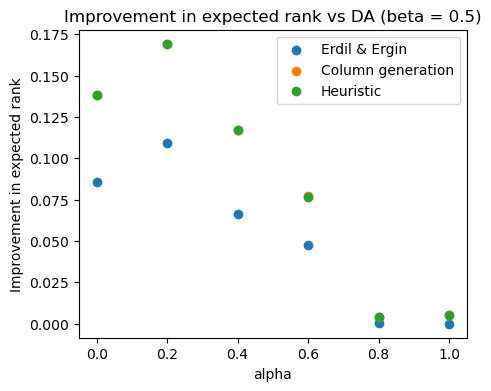

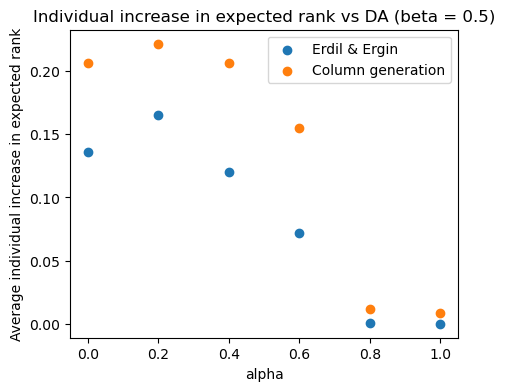

In [24]:
name = 'SIM_2025-06-23_174124.plk'
print(len(S_vector))
SimulationsEvaluate(S_vector, name, False)

## Estonian data

In [18]:
file_path = "ReadData/Estonia/data_anon.txt" 
MyData = read_dataEstonia(file_path)
print(MyData)

The data instance has the following properties: 

	152 students.
	7 schools. 

 	PREFERENCES:
	1	2 3 6 5 7 1 4 
	2	4 3 6 7 5 2 1 
	3	2 5 3 6 7 1 4 
	4	5 7 2 3 6 1 4 
	5	6 3 5 7 2 1 4 
	6	2 3 5 7 1 6 4 
	7	3 6 2 5 7 1 4 
	8	4 1 2 3 6 7 5 
	9	6 3 2 5 7 1 4 
	10	5 3 2 7 1 6 4 
	11	3 2 5 4 6 7 1 
	12	5 2 1 7 6 3 4 
	13	2 3 5 7 6 1 4 
	14	4 1 3 2 5 7 6 
	15	6 3 2 1 5 4 7 
	16	5 2 7 3 1 6 4 
	17	2 5 3 7 6 1 4 
	18	3 6 2 5 4 1 7 
	19	6 3 2 5 7 1 4 
	20	7 5 2 4 3 6 1 
	21	3 6 2 5 7 1 4 
	22	2 5 7 3 1 4 6 
	23	6 2 5 3 7 1 4 
	24	5 3 2 7 1 6 4 
	25	2 5 3 6 1 7 4 
	26	3 2 5 7 1 6 4 
	27	2 6 3 5 4 7 1 
	28	2 3 4 1 5 6 7 
	29	2 5 3 6 7 4 1 
	30	6 3 4 2 5 7 1 
	31	6 3 2 5 7 1 4 
	32	5 6 3 7 1 4 2 
	33	6 3 5 2 1 7 4 
	34	5 3 2 7 6 1 4 
	35	6 3 2 5 7 1 4 
	36	3 2 5 1 7 6 4 
	37	1 2 4 5 7 6 3 
	38	2 5 3 6 7 1 4 
	39	7 1 2 5 6 3 4 
	40	2 3 1 5 6 4 7 
	41	2 3 6 5 7 1 4 
	42	3 5 7 2 6 1 4 
	43	3 2 5 6 7 1 4 
	44	2 6 3 5 4 1 7 
	45	5 7 3 1 2 6 4 
	46	2 3 6 5 4 1 7 
	47	5 2 3 7 6 4 1 
	48	3 2 5 6 7 1 4 
	49

In [19]:
# Generate the assignment from DA with Single Tie-Breaking with n_iter samples
n_iter = 1000
bool_SIC = False # Run SICs immediately?
A = DA_STB(MyData, n_iter, 'GS', bool_SIC, 0, True)

# Find Stable improvement cycles à la Erdil and Ergin (2008)
A_SIC = SIC_all_matchings(MyData, A, True)
print(A.assignment)

Students in ties: 152
Tie-breaking rules sampled: 1000


Generate DA_STB: 100%|██████████| 1000/1000 [00:06<00:00, 156.48perturb/s]


STATISTICS BEFORE:

Average rank: 1.8237565789473678.



Compute SICs for matchings: 100%|██████████| 1000/1000 [00:01<00:00, 907.87matching/s]


STATISTICS AFTER:

Average rank: 1.8015394736842112.

[[0.    0.645 0.355 ... 0.    0.    0.   ]
 [0.055 0.    0.    ... 0.    0.    0.   ]
 [0.    0.665 0.095 ... 0.24  0.    0.   ]
 ...
 [0.    0.    0.296 ... 0.    0.704 0.   ]
 [0.    0.    0.    ... 0.    1.    0.   ]
 [0.073 0.    0.    ... 0.    0.    0.   ]]


In [20]:
# Solve the formulations
MyModel = ModelColumnGen(MyData, A_SIC, A.assignment, True)
#MyModel = ModelColumnGen(MyData, A_SIC, A_SIC.assignment, True) # Compare to A_SIC

timeLimit = 60
S = MyModel.Solve("TRAD", "GUROBI", print_log=False, time_limit=timeLimit, print_out=True)
#q = MyModel.Solve("STABLE", "GUROBI", True)

Master: add decision variables: 100%|██████████| 1000/1000 [00:03<00:00, 261.56var/s]
c:\Users\tdemeule\AppData\Local\anaconda3\Lib\site-packages\pulp\pulp.py:1423: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")



Average rank DA : 1.8237565789473678.


Average rank warm start solution : 1.8015394736842112.




Pricing exclude found matchings: 100%|██████████| 1000/1000 [00:07<00:00, 140.07matchings/s]


Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.7828273791936493
Constant term -0.11128261558420396

 ****** PRICING ****** 

New time limit 58.53100000019185
		Objective pricing:  8.923970159385263
Pricing status 1
New number of matchings: 1001
ITERATION: 2

 ****** MASTER ****** 

Objective master:  1.7828273791936493
Constant term -0.11128261558420396

 ****** PRICING ****** 

New time limit 53.062000000150874
		Objective pricing:  8.588734582098942
Pricing status 1
New number of matchings: 1002
ITERATION: 3

 ****** MASTER ****** 

Objective master:  1.7828273791936493
Constant term -0.11128261558420396

 ****** PRICING ****** 

New time limit 47.82799999997951
		Objective pricing:  8.88264211270042
Pricing status 1
New number of matchings: 1003
ITERATION: 4

 ****** MASTER ****** 

Objective master:  1.7828273791936493
Constant term -0.11128261558420396

 ****** PRICING ****** 

New time limit 41.390000000130385
		Objective pricing:  8.75687442

In [21]:
# Compare resulting assignment with DA
result = S.A.compare(S.A_DA_prob)
resultEE = S.A_SIC.compare(S.A_DA_prob)
print(resultEE)
print(result)
print("Number of improving students EE & us", resultEE['n_students_improving'], result['n_students_improving'])
print("Average improvement rank EE & us", resultEE['average_rank_increase'], result["average_rank_increase"])
print("Median rank improvement", resultEE['median_rank_improvement'], result['median_rank_improvement'])


{'students_improving': [False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, True, True, False, True, True, False, True, True, False, False, False, False, False, True, False, False, False, False, True, False, False, False, True, False, False, False, False, False, True, True, False, True, False, True, False, False, True, True, False, True, False, True, True, True, False, False, False, True, True, False, True, False, False, False, False, True, True, True, True, True, True, False, True, True, True, True, False, True, True, False, True, False, False, True, True, False, True, False, False, True, True, True, False, True, False, False, False, True, False, False, False, True, False, False, True, False, False, False, False, False, True, False, False, False, False, True, True, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False

In [ ]:
# Generate a second subset of matchings, and test column generation with that
# (10 June 2025: not yet configured for use of warm start)
n_iter = 1000
bool_SIC = True # Run SICs immediately?
B = DA_STB(MyData, n_iter, 'GS', bool_SIC, 1, True)
B_SIC = SIC_all_matchings(MyData, B, True)
A_SIC.M_set = copy.deepcopy(B_SIC.M_set)
MyModel2 = ModelColumnGen(MyData, A_SIC, A.assignment, True)
qq = MyModel2.Solve("TRAD", "GUROBI", print_log=True, print_out=False)


## Run initial IP on generated data
Specify the number of students and schools, and run the models for this data.

In [ ]:
# Generate random data
parameters = DataGenParam(mean_pref = 6, capacity_ratio = 1) # Default parameters, except for mean_pref and capacity_ratio
#MyData = generate_data(n_students=400, n_schools=20, parameters = parameters, name="Test_DataGen", print_data=False, seed = 15)
MyData = generate_data(n_students=1000, n_schools=50, parameters = parameters, name="Test_DataGen_EE_vs_GS", print_data=False, seed = 0)

In [ ]:
# Print data if desired
print(MyData)

In [ ]:
# Generate the assignment from DA with Single Tie-Breaking with n_iter samples
n_iter = 20
bool_SIC = True # Run SICs immediately?
A = DA_STB(MyData, n_iter, 'GS', bool_SIC, 0, True)
print(A.assignment)

In [ ]:
# Solve the formulations
    # 'IMPR_RANK' refers to minimizing the expected rank while ensuring ex-post stability
    # 'STABLE' refers to maximizing the fraction of STABLE matchings in the decomposition
MyModel = Model(MyData, A, True)
q = MyModel.Solve("IMPR_RANK", "GUROBI", True)
#q = MyModel.Solve("STABLE", "GUROBI", True)

In [ ]:
# Print the solution
MyModel.print_solution()

In [ ]:
# Asses and visualize the difference
name_diff = name + '_diff'
diff = Assignment(MyData, q.assignment - A.assignment, name_diff)
diff.visualize()

## Heuristic subset weakly stable matchings
Runs an LP that minimizes the average rank while stochastically dominating the DA assignment with single-tie breaking, and while only using matchings that were used to compute DA probabilities. This is a heuristic.

In [ ]:
# Generate random data
parameters = DataGenParam(mean_pref = 5, capacity_ratio = 1) # Default parameters, except for mean_pref and capacity_ratio
#MyData = generate_data(n_students=400, n_schools=20, parameters = parameters, name="Test_DataGen", print_data=False, seed = 15)
MyData = generate_data(n_students=10, n_schools=4, parameters = parameters, name="500_25", print_data=False, seed = 1)

In [ ]:
# Print data if desired
print(MyData)

In [ ]:
# Generate the assignment from DA with Single Tie-Breaking with n_iter samples
n_iter = 1000
bool_SIC = True # Run SICs immediately?
A = DA_STB(MyData, n_iter, 'GS', bool_SIC, 0, True)
print(A.assignment)

In [ ]:
# Solve the formulations
    # 'IMPR_RANK' refers to minimizing the expected rank while ensuring ex-post stability
MyModel = ModelHeuristicLP(MyData, A, True)
q = MyModel.Solve("IMPR_RANK", "GUROBI", True)
#q = MyModel.Solve("STABLE", "GUROBI", True)

In [ ]:
# Print the solution
MyModel.print_solution()

In [ ]:
print(np.max(q.assignment-A.assignment))

In [ ]:
# Asses and visualize the difference
diff = Assignment(MyData, q.assignment - A.assignment, "40_12_Diff")
diff.visualize()

## Heuristic Fractional stable random matching

In [ ]:
# Solve the formulations
    # 'IMPR_RANK' refers to minimizing the expected rank while ensuring ex-post stability
MyModelFS = ModelFracStable(MyData, A, True)
q = MyModelFS.Solve("IMPR_RANK", "GUROBI", True)
#q = MyModel.Solve("STABLE", "GUROBI", True)

In [ ]:
# FInd decomposition over weakly stable matchings of this fractionally stable matching (if decomposition exists)
MyModelCHECK = Model(MyData, q, True)
q_check = MyModelCHECK.Solve("STABLE", "GUROBI", True)

## Run code manual data
Manually enter data.

In [ ]:
# Define preferences of the students
# 'pref[i][k]' contains the position of the k-th ranked school in the preferences.
# We assume the preferences to be strict
# Note that preferences can be strict. We indicate this by a tuple () in the list.

# Example paper
n_stud = 4
n_schools = 4

file_name = "Ex_paper"

# Preferences students
pref = [['1', '3', '4', '2'],
       ['1','4','3','2'],
       # ['1', '4'],
       ['2','3', '4', '1'],
       ['2', '4', '3', '1']]

# Priorities schools
prior = [[('A', 'B'), 'C', 'D'],
        [('C', 'D'), 'A', 'B'],
        ['B', 'D', ('A', 'C')],
        ['A', 'C', ('B', 'D')]]


# Capacities schools
cap = [1,1,1,1]

# Names of students and schools
ID_stud = ["A", "B", "C", "D"]
ID_school = ["1", "2", "3", "4"]

# Also create the random matching upon which we want to improve
p = np.zeros(shape=(n_stud, n_schools))
p[0][0] = 1/2
p[1][0] = 1/2
p[2][1] = 1/2
p[3][1] = 1/2
p[0][2] = 3/8
p[2][2] = 3/8
p[1][3] = 3/8
p[3][3] = 3/8
p[0][3] = 1/8
p[2][3] = 1/8
p[1][2] = 1/8
p[3][2] = 1/8

In [ ]:
# Generate a data instance (and print it)
MyData = Data(n_stud, n_schools, pref, prior, cap, ID_stud, ID_school, file_name)
print(MyData)


In [ ]:
# Generate an Assignment instance (and visualize it)
A = Assignment(MyData, p, "Ex_paper")

# To visualize assignment
A.visualize()

In [ ]:
# Solve the formulations
    # 'IMPR_RANK' refers to minimizing the expected rank while ensuring ex-post stability
    # 'STABLE' refers to maximizing the fraction of STABLE matchings in the decomposition
MyModel = Model(MyData, A, False)
q = MyModel.Solve("IMPR_RANK", "GUROBI", False)
#q = MyModel.Solve("STABLE", "GUROBI", True)

In [ ]:
# Print the solution
MyModel.print_solution()

In [ ]:
# Asses and visualize the difference
diff = Assignment(MyData, q.assignment - p, "Ex_paper_Diff")
diff.visualize()

In [ ]:
tuple([1,2])

# Erdil & Ergin experiments

In [ ]:
# Define preferences of the students
# 'pref[i][k]' contains the position of the k-th ranked school in the preferences.
# We assume the preferences to be strict
# Note that preferences can be strict. We indicate this by a tuple () in the list.

# Example paper
n_stud = 4
n_schools = 4

file_name = "Ex_paper"

# Preferences students
pref = [['1', '3', '4', '2'],
       ['1','4','3','2'],
       # ['1', '4'],
       ['2','3', '4', '1'],
       ['2', '4', '3', '1']]

# Priorities schools
prior = [[('A', 'B'), 'C', 'D'],
        [('C', 'D'), 'A', 'B'],
        ['B', 'D', ('A', 'C')],
        ['A', 'C', ('B', 'D')]]


# Capacities schools
cap = [1,1,1,1]

# Names of students and schools
ID_stud = ["A", "B", "C", "D"]
ID_school = ["1", "2", "3", "4"]

# Also create the random matching upon which we want to improve
p = np.zeros(shape=(n_stud, n_schools))
p[0][0] = 1/2
p[1][0] = 1/2
p[2][1] = 1/2
p[3][1] = 1/2
p[0][2] = 3/8
p[2][2] = 3/8
p[1][3] = 3/8
p[3][3] = 3/8
p[0][3] = 1/8
p[2][3] = 1/8
p[1][2] = 1/8
p[3][2] = 1/8

# Generate a data instance (and print it)
MyData = Data(n_stud, n_schools, pref, prior, cap, ID_stud, ID_school, file_name)
print(MyData)


In [ ]:
# Do tie-breaking
permut = generate_permutations_STB(MyData, 1, seed = 3)

prior_new = generate_strict_prior_from_perturbation(MyData, permut[0])

Data_new_prior = Data(MyData.n_stud, MyData.n_schools, MyData.pref, prior_new, MyData.cap, MyData.ID_stud, MyData.ID_school, MyData.file_name)

# DA code Erdil & Ergin
N = transform_pref_us_to_EE(Data_new_prior)
A = transform_prior_us_to_EE(Data_new_prior)
Q = MyData.cap
result = DA_Erdil_ergin(N,A,Q)
print(result)
print(type(result['proposeoffset']))

M = gale_shapley(Data_new_prior)
print(type(M))
print(M)

M = np.zeros((4,4))
M[0,1] = 1
M[1,2] = 1
M[2,3] = 1
M[3,0] = 1
print(M)
print(M[0,1] == 1)

M_out = SIC(MyData, M, False)
print(M_out)

In [ ]:
bool_SIC = False # Run SICs immediately?
AssignmentGS = DA_STB(MyData, 10, 'GS', bool_SIC, 0)
ASIC = SIC_all_matchings(MyData, AssignmentGS, True)

print(AssignmentGS.assignment)




# Quick tests


In [ ]:
n_stud = 2000
n_schools = 30
pref_list_length = n_schools
alpha_in = 0.2
beta_in = 0
seed = 1
MyData = DataGenEE(n_stud, n_schools, alpha_in, beta_in, pref_list_length, True, seed)
print(MyData)


In [ ]:
ALPHA_INCREMENT = 0.2
BETA_INCREMENT = 0.4

alpha_list = list(np.arange(0, 1.0, ALPHA_INCREMENT)) 
beta_list = list(np.arange(0, 1.0, BETA_INCREMENT))

print(alpha_list)
print(type(alpha_list))
